## Constant definitions
In order to load historical files we need to define some constants to get data from

In [1]:
from ism import ism
from ism import HTML_EXTENSION, TS_FORMAT
import pandas as pd
import pathlib
import numpy as np
from datetime import datetime
SERVICES_TAGS_NAME = "scoring-tables/servicestags.csv"
MANUFACTURING_TAGS_NAME = "scoring-tables/manufacturingtags.csv"
SERVICES_INDUSTRIES_NAME = "scoring-tables/servicesindustries.csv"
MANUFACTURING_INDUSTRIES_NAME = "scoring-tables/manufacturingindustries.csv"

HISTORICAL_DIR="historical/"


### Init scrapper
We must init the web scrapper before start

In [2]:
scrapper=ism()
manufacturing_tags_df = scrapper.read_csv(MANUFACTURING_TAGS_NAME)
manufacturing_tags_df.set_index(manufacturing_tags_df.columns.values[0], inplace=True)
manufacturing_industries_df = scrapper.read_csv(MANUFACTURING_INDUSTRIES_NAME, separator=';')

services_tags_df = scrapper.read_csv(SERVICES_TAGS_NAME)
services_tags_df.set_index(services_tags_df.columns.values[0], inplace=True)
services_industries_df = scrapper.read_csv(SERVICES_INDUSTRIES_NAME, separator=';')

historical = pathlib.Path(HISTORICAL_DIR)

Now we can load the historical webpages:

In [3]:
df_services={}
df_manufacturing={}
manufacturing_count = 0
for item in historical.rglob("*"+HTML_EXTENSION):
    if item.is_file():
        web = scrapper.read_file(str(item))
        if "/" in str(item):
            report = str(item).split("_")[0].split("/")[-1]
        else:
            report = str(item).split("_")[0].split("\\")[-1]
        if report == "services":
            d = scrapper.find_match(web, services_tags_df[services_tags_df.columns.values[0]].values, 
                            offset=services_tags_df[services_tags_df.columns.values[1]].values, 
                            categories = services_tags_df.index.values)
            mult={services_tags_df.index.values[i]:services_tags_df.iloc[i][services_tags_df.columns.values[2]]
                            for i in range(len(services_tags_df))}
            scores = scrapper.score(d, services_industries_df[services_industries_df.columns.values[0]].values, 
                              mult)
        else:
            d = scrapper.find_match(web, manufacturing_tags_df[manufacturing_tags_df.columns.values[0]].values, 
                            offset=manufacturing_tags_df[manufacturing_tags_df.columns.values[1]].values, 
                            categories = manufacturing_tags_df.index.values)
            mult={manufacturing_tags_df.index.values[i]:manufacturing_tags_df.iloc[i][manufacturing_tags_df.columns.values[2]]
                            for i in range(len(manufacturing_tags_df))}
            scores = scrapper.score(d, manufacturing_industries_df[manufacturing_industries_df.columns.values[0]].values, 
                              mult)
        df = pd.DataFrame.from_dict(scores, orient='index')
        s = df.sum(axis=1).squeeze().sort_values()
        dates = datetime.strptime(str(str(item).split("_")[1].split(".")[0]), TS_FORMAT)
        df = pd.DataFrame(index=[dates],data=s.to_dict())
        if report == "services" and len(df_services) == 0:
            df_services = df
        elif report == "services":
            df_services = pd.concat([df_services,df])
        elif len(df_manufacturing) == 0:
            df_manufacturing = df
        else:
            df_manufacturing = pd.concat([df_manufacturing,df])
df_manufacturing.sort_index(inplace=True)
df_services.sort_index(inplace=True)

Now we insert a common starting point

In [4]:
reference = df_manufacturing.index.values[0].astype('datetime64[M]')-np.timedelta64(1, 'M')
df = pd.DataFrame(data={c:[0] for c in df_manufacturing.columns.values}, index = [reference])
df_manufacturing = pd.concat([df, df_manufacturing])
df = pd.DataFrame(data={c:[0] for c in df_services.columns.values}, index = [reference])
df_services = pd.concat([df, df_services])

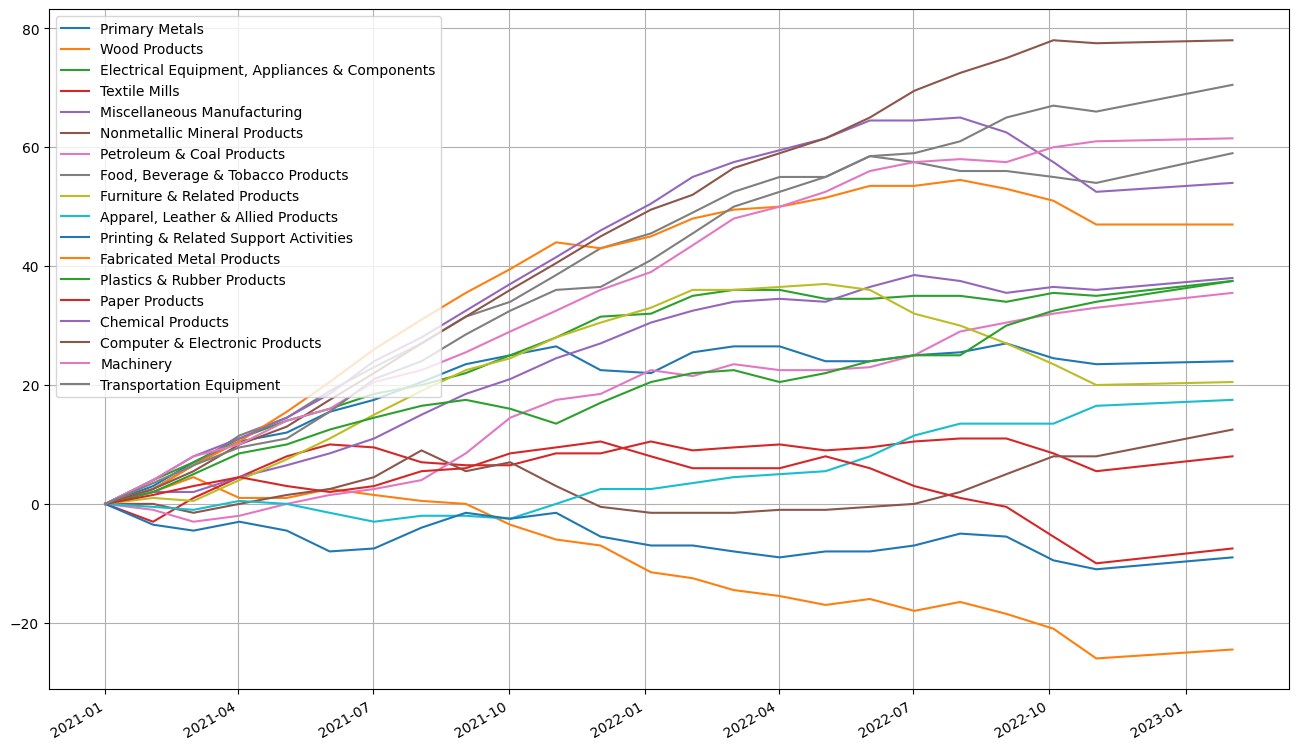

In [5]:
%matplotlib inline
df_manufacturing.cumsum().plot(figsize=[16,10], grid=True);